# Standard Imports

In [ ]:
import numpy as np
from matplotlib import pyplot
%matplotlib notebook

# Section 1: See what different SNRs look like in images

The first half of this notebook expects to be able to import modules from the LSST DM stack (and a relatively recent version) and get some HSC data at a filesystem location you probably don't have.
It could be modified easily to run on the tiger or pegasus clusters, where that software and similar data are also available.

You can skip down to the next section if you just want to play with the effect of different priors on different input SNRs.

In [41]:
from lsst.daf.persistence import Butler
from lsst.afw.display import Display
from lsst.afw import geom
from lsst.afw import image
Display.setDefaultBackend("matplotlib")

In [3]:
butler = Butler("/datasets/hsc/repo/rerun/RC/w_2018_10/DM-13647/")

In [4]:
coadd = butler.get("deepCoadd_calexp", tract=9813, patch="4,4", filter="HSC-I")

In [5]:
catalog = butler.get("deepCoadd_meas", tract=9813, patch="4,4", filter="HSC-I")

In [6]:
calib = coadd.getCalib()

In [7]:
box = geom.Box2D()
box.include(geom.Point2D(18095, 17989))
box.grow(geom.Extent2D(40, 40))
box = geom.Box2I(box)

In [8]:
subcat = catalog[np.logical_and.reduce([catalog.getX() > box.getMinX(),
                                        catalog.getX() < box.getMaxX(),
                                        catalog.getY() > box.getMinY(),
                                        catalog.getY() < box.getMaxY()])].copy(deep=True)

In [9]:
subimg = coadd[box, image.PARENT]

In [10]:
bright_record = subcat[2]
faint_record = subcat[4]

In [126]:
bright_record.getPsfFlux()/bright_record.getPsfFluxErr()

862.2164323463822

<IPython.core.display.Javascript object>


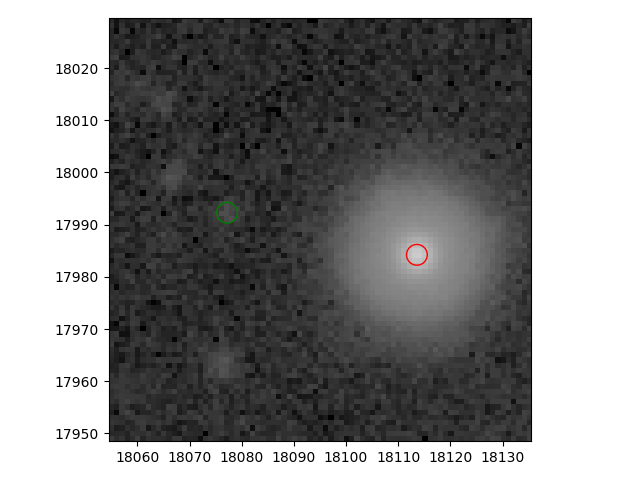

In [11]:
d = Display(frame=0, backend="matplotlib")
d.setMaskTransparency(100)
d.scale("asinh", min=-0.05, max=0.2, unit="absolute")
d.mtv(subimg)
def show(record, **kwds):
    d.dot("o", record.getX(), record.getY(), **kwds)
show(bright_record, ctype='red')
show(faint_record, ctype='green')

# Section 2: Explore the effect of power-law priors on flux posteriors
This section uses two bits of code from the previous section:
 - We use the measurements from `bright_record` and `faint_record` to initialize some `FluxMeasurement` objects to play with.
 - We use the `calib` object to convert between fluxes and magnitudes.  If you don't have the LSST stack available, just write a class that has `getFlux(mag)` and `getMagnitude(flux)` methods to convert back and forth, and call it `calib`.

In [12]:
class FluxMeasurement:
    
    def __init__(self, flux, err):
        self.flux = flux
        self.err = err

    def with_snr(self, s):
        return FluxMeasurement(s*self.err, self.err)
        
    @property
    def snr(self):
        return self.flux/self.err
    
    @property
    def mag(self):
        return calib.getMagnitude(self.flux)
    
    def likelihood(self, flux_array):
        return np.exp(-0.5*((flux_array - self.flux)/self.err)**2)

In [58]:
class PowerLawPrior:
    
    def __init__(self, slope):
        self.slope = slope
        
    def __call__(self, flux_array):
        return flux_array**(-(1.0 + self.slope))

    def max_posterior(self, measurement):
        return measurement.flux*0.5*(1.0 + (1.0 - 4*(self.slope + 1.0)/measurement.snr**2)**0.5)

In [59]:
bright = FluxMeasurement(bright_record.getPsfFlux(), bright_record.getPsfFluxErr())
faint = FluxMeasurement(faint_record.getPsfFlux(), faint_record.getPsfFluxErr())
fainter = faint.with_snr(5.0)
faintest = faint.with_snr(3.0)

In [123]:
def show_posterior(measurement, prior, m1=1.0, m2=4.0, mmax=40):
    n = 100
    mag_array_1 = np.linspace(measurement.mag - m1, measurement.mag + m2, n)
    flux_array_1 = calib.getFlux(mag_array_1)
    flux_array_2 = np.logspace(np.log10(calib.getFlux(mmax)),
                               np.log10(flux_array_1[-1]), n)[::-1]
    mag_array_2 = calib.getMagnitude(flux_array_2)
    mag_array = np.concatenate([mag_array_1, mag_array_2])
    flux_array = np.concatenate([flux_array_1, flux_array_2])
    pyplot.figure(figsize=(7, 5))
    def normalize(array):
        return array / np.trapz(array[:n], mag_array[:n])
    likelihood_array = normalize(measurement.likelihood(flux_array))
    prior_array = normalize(prior(flux_array))
    posterior_array = normalize(prior_array*likelihood_array)
    pyplot.subplot(1, 2, 1)
    pyplot.ylabel("probability density (locally normalized)")
    pyplot.xlabel("magnitude")
    pyplot.plot(mag_array[:n], likelihood_array[:n], label='likelihood')
    pyplot.plot(mag_array[:n], prior_array[:n], label='prior')
    c, = pyplot.plot(mag_array[:n], posterior_array[:n], label='posterior')
    mode = prior.max_posterior(measurement)
    if np.isreal(mode):
        pyplot.axvline(calib.getMagnitude(mode), color=c.get_color(),
                       linestyle=':', label='local posterior mode')
    mean = np.trapz(flux_array*posterior_array, flux_array)/np.trapz(posterior_array, flux_array)
    if mean < flux_array[0] and mean > flux_array[n]:
        pyplot.axvline(calib.getMagnitude(mean), color=c.get_color(),
                       linestyle='--', label='posterior mean')
    pyplot.legend()
    ax = pyplot.subplot(1, 2, 2)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    pyplot.ylabel("probability density (normalized by left plot)")
    pyplot.xlabel("magnitude")
    pyplot.plot(mag_array[n:], likelihood_array[n:], label='likelihood')
    pyplot.plot(mag_array[n:], prior_array[n:], label='prior')
    pyplot.plot(mag_array[n:], posterior_array[n:], label='posterior')
    if mean < flux_array[n] and mean > flux_array[-1]:
        pyplot.axvline(calib.getMagnitude(mean), color=c.get_color(),
                       linestyle='--', label='posterior mean')
    pyplot.legend()
    pyplot.semilogy()

<IPython.core.display.Javascript object>


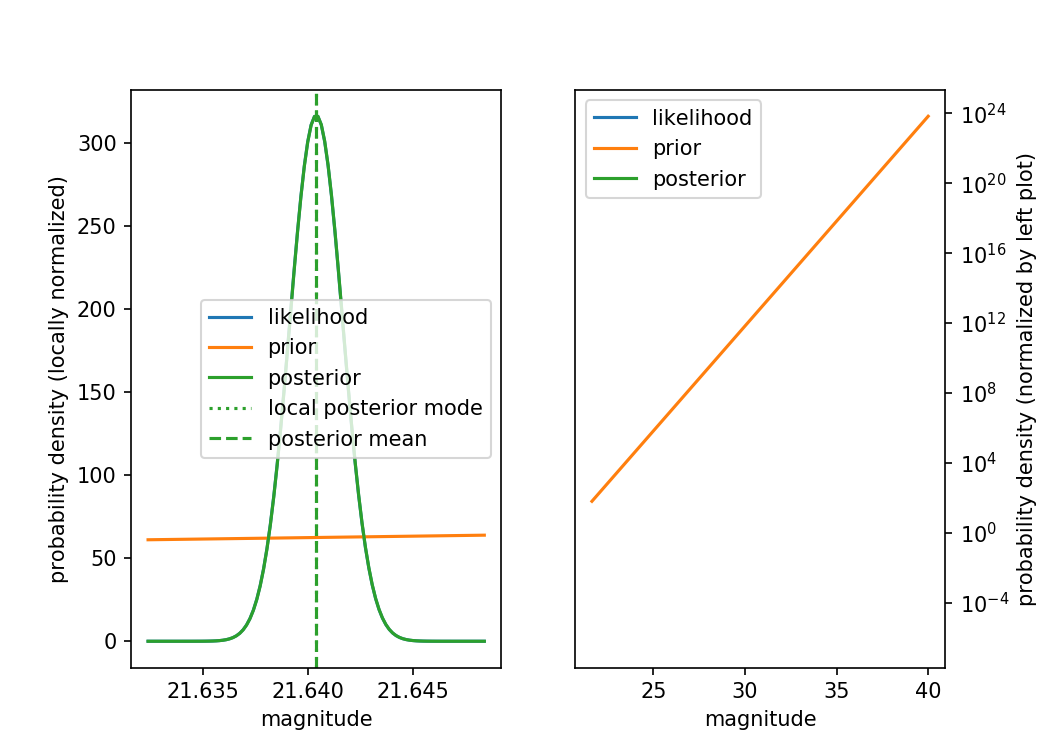

In [127]:
show_posterior(bright, PowerLawPrior(2.0), m2=0.008, m1=0.008, mmax=40)

<IPython.core.display.Javascript object>


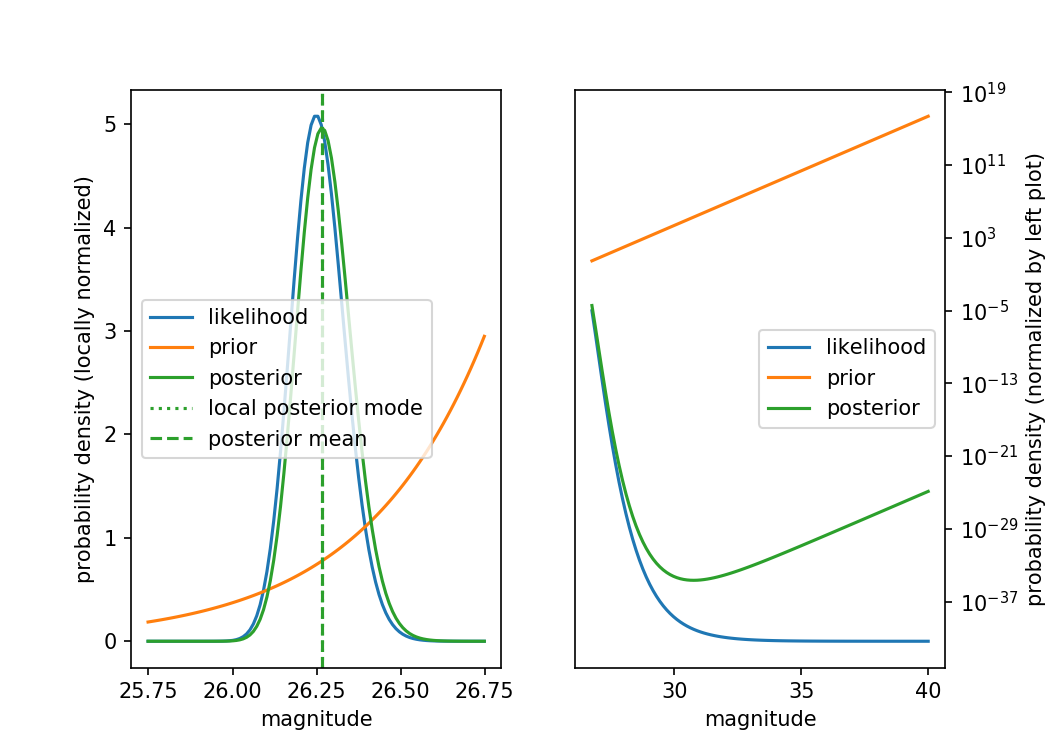

In [129]:
show_posterior(faint, PowerLawPrior(2.0), m2=0.5, m1=0.5)

<IPython.core.display.Javascript object>


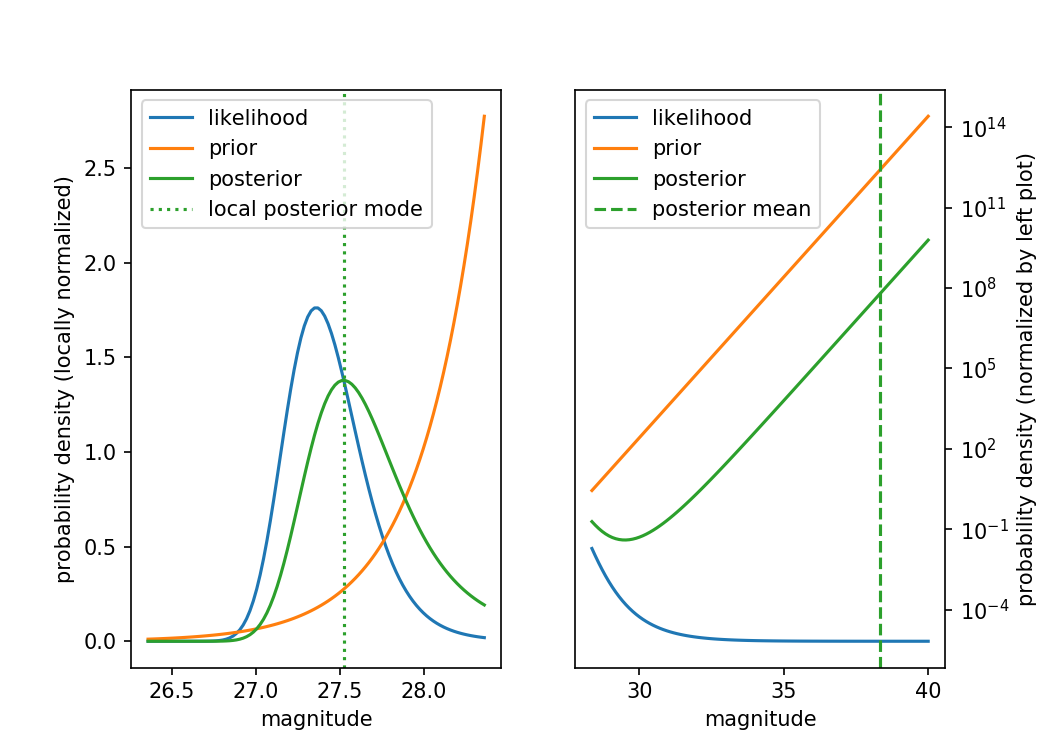

In [130]:
show_posterior(fainter, PowerLawPrior(2.0), m2=1, m1=1)

<IPython.core.display.Javascript object>


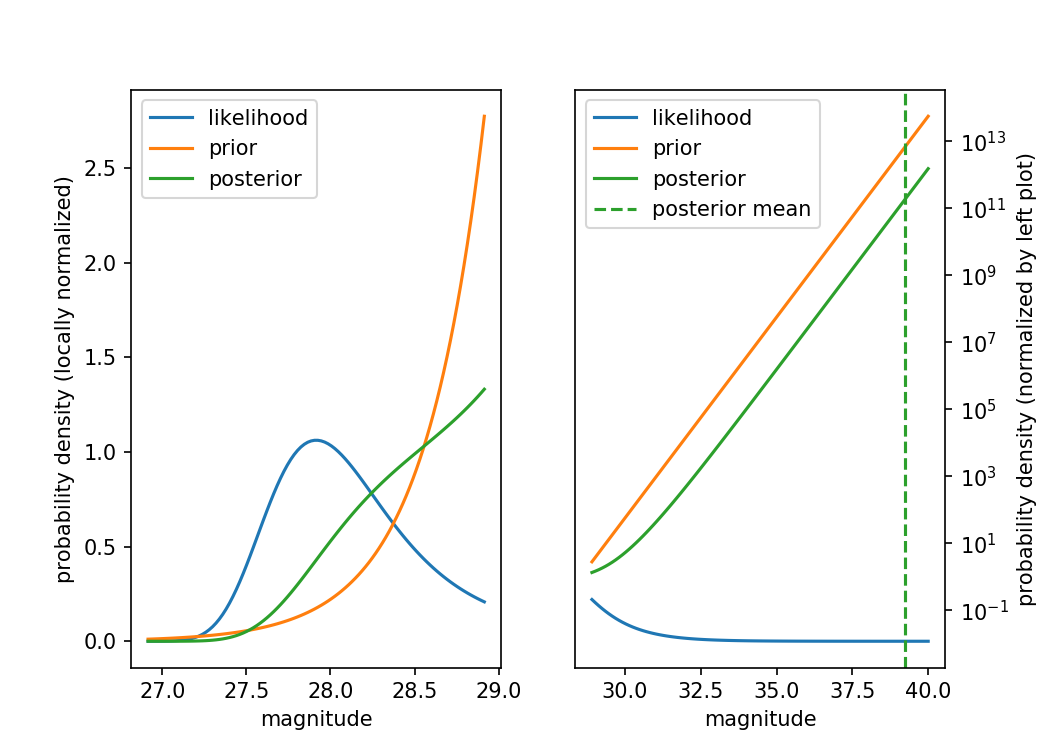

In [131]:
show_posterior(faintest, PowerLawPrior(2.0), m2=1, m1=1)